In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [16]:
# Load dataset
df = pd.read_csv("spotify-2023.csv", encoding="ISO-8859-1")


In [17]:
#Define Popularity Category 
df["streams"] = pd.to_numeric(df["streams"], errors='coerce')

# Drop any rows where streams couldn't be converted
df = df.dropna(subset=["streams"])

# Categorize popularity
def categorize(streams):
    if streams > 200_000_000:
        return "Super Hit"
    elif streams > 100_000_000:
        return "Hit"
    elif streams > 50_000_000:
        return "Moderate"
    else:
        return "Less Popular"

In [8]:
# Select relevant features and target
features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%']
target = 'popularity_category'

In [9]:
# Drop missing values
df = df[features + [target]].dropna()

In [10]:
# Encode target labels
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])


In [11]:
# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Classification Report:
               precision    recall  f1-score   support

         Hit       0.42      0.19      0.26        42
Less Popular       0.00      0.00      0.00         3
    Moderate       0.00      0.00      0.00        27
   Super Hit       0.65      0.92      0.76       119

    accuracy                           0.61       191
   macro avg       0.27      0.28      0.26       191
weighted avg       0.50      0.61      0.53       191



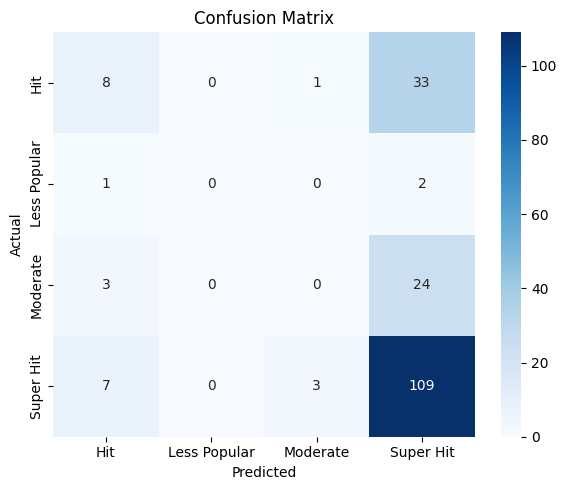

✅ Model training complete! Confusion matrix saved as 'confusion_matrix.png'


In [14]:
# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

print("✅ Model training complete! Confusion matrix saved as 'confusion_matrix.png'")


In [19]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

# Load model and scaler
model = joblib.load("rf_model.pkl")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    try:
        features = [data["danceability_%"], data["valence_%"], data["energy_%"],
                    data["acousticness_%"], data["instrumentalness_%"]]
        X = scaler.transform([features])
        pred = model.predict(X)[0]
        category = label_encoder.inverse_transform([pred])[0]
        return jsonify({"predicted_category": category})
    except Exception as e:
        return jsonify({"error": str(e)}), 400

if __name__ == '__main__':
    app.run(debug=True)


ModuleNotFoundError: No module named 'flask'